# Discrete Dynamical systems

Overall logic: Although similar to the continuous case, where all systems are Hamiltonian, integration is trivial.

* Define a discrete map and its inverse - limited to 2D maps
* Define a 2D grid to sample points
* Define a common number of iterations
* Iterate map and compute LD function on the fly
* Plot LD map in 2D grid




In [13]:
import numpy as np
from pylds import base

## Standard map

REFERENCES
* http://www.scholarpedia.org/article/Chirikov_standard_map

\begin{align*}
x_{n+1} &= x_n + K sin( y_n ) ,\quad \text{mod } 2\pi \\
y_{n+1} &= y_n + x_{n+1} ,\quad \text{mod } 2\pi
\end{align*}

\begin{align*}
x_{n+1} &= x_n + y_n - \frac{K}{2\pi} sin(2\pi x_n ) ,\quad \text{mod } 1 \\
y_{n+1} &= y_n - \frac{K}{2\pi} sin(2\pi x_n ) ,\quad \text{mod } 1
\end{align*}

In [46]:
def StandardMap(u_initial, PARAMETERS=[0.3]):
    """
    Returns 1D Hamilton-Centre vector field at time t, for an array of points in phase space.
    Number of model parameters: 1 . PARAMETERS = [omega]
    Functional form: v = (omega*y, - omega*x), with u = (x, y)
    
    Parameters
    ----------
    u : array_like, shape(n,)
        points in phase space to determine vector field at time t
    
    PARAMETERS : list of floats
        vector field parameters
    
    Returns
    -------
    v : array_like, shape(n,)
        vector field corresponding to points u, in phase space at time t
    """
    x_initial, y_initial = u_initial.T
    # Hamiltonian Model Parameter
    K, = PARAMETERS
    
    # Map components 
    x_next = x_initial + y_initial - (K/(2*np.pi))*np.sin(2*np.pi*x_initial)
    y_next = y_initial - (K/(2*np.pi))*np.sin(2*np.pi*x_initial)
    
    # Map next iteration
    u_next = np.array([ x_next, y_next]).T

    return u_next

In [30]:
def StandardMap_inverse(u_initial, PARAMETERS=[0.3]):
    """
    Returns 1D Hamilton-Centre vector field at time t, for an array of points in phase space.
    Number of model parameters: 1 . PARAMETERS = [omega]
    Functional form: v = (omega*y, - omega*x), with u = (x, y)
    
    Parameters
    ----------
    u : array_like, shape(n,)
        points in phase space to determine vector field at time t
    
    PARAMETERS : list of floats
        vector field parameters
    
    Returns
    -------
    v : array_like, shape(n,)
        vector field corresponding to points u, in phase space at time t
    """
    x_initial, y_initial = u_initial.T
    # Hamiltonian Model Parameter
    K, = PARAMETERS
    
    # Map components 
    x_next = x_initial - y_initial
    y_next = y_initial + (K/(2*np.pi))*np.sin(2*np.pi*(x_initial - y_initial))
    
    # Map next iteration
    u_next = np.array([ x_next, y_next]).T

    return u_next

In [72]:
grid_parameters = [[-0.5, 0.5, 20],[-0.5, 0.5, 20]]

In [73]:
points_original, mask = base.generate_points(grid_parameters)
points_original = points_original.reshape(-1,3)
points_original = points_original[:,:-1]

N_iterations = 200
f = StandardMap

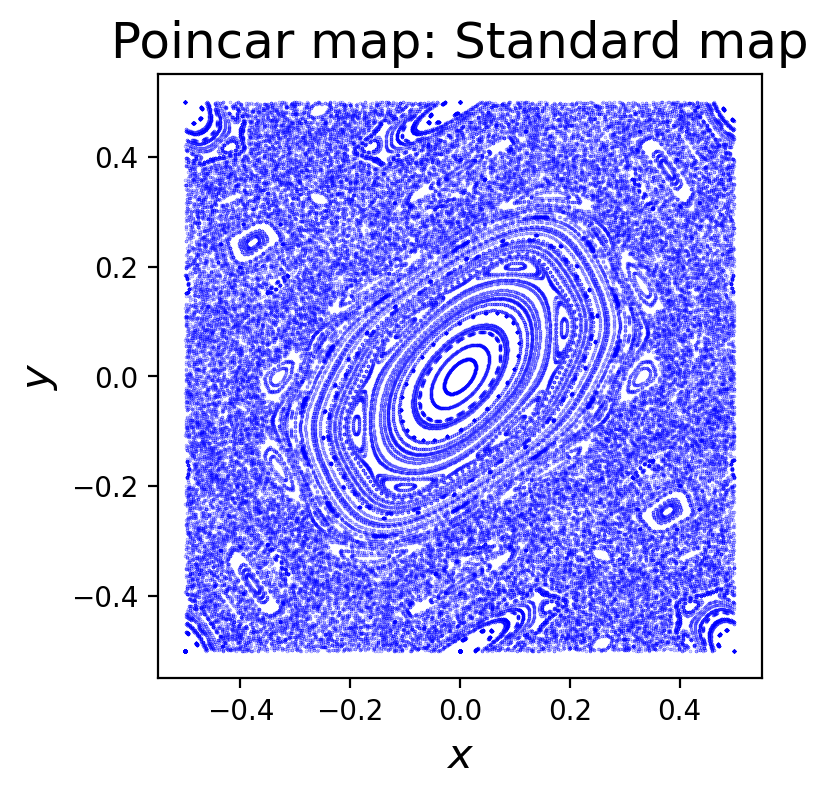

In [76]:
import matplotlib.pyplot as plt

fig = plt.figure(dpi=200)

for k in range(len(points_original)):
    points_initial = points_original[k]
    trajectory = []
    for i in range(N_iterations):
        points_next = f(points_initial, PARAMETERS=[1.2])
        points_next = points_next - np.floor(points_next + 1/2)

        trajectory.append(points_next)
        
        points_initial = points_next
        
    plt.scatter(*np.array(trajectory).T,c='blue',s=0.05,alpha=0.5)

plt.gca().set_aspect('equal', adjustable='box')
plt.title("Poincar map: Standard map", fontsize=18)
plt.xlabel('$x$', fontsize=15)
plt.ylabel('$y$', fontsize=15)
plt.show()

# Implementation 

In [1]:
import numpy as np
from operator import itemgetter
from functools import lru_cache
from pylds.tools import draw_lagrangian_descriptor
from pylds.base import generate_points, lagrangian_descriptor

In [62]:
def compute_lagrangian_descriptor(grid_parameters, discrete_map, N_iterations, p_value=0.5, box_boundaries=False):
    y0, mask = generate_points(grid_parameters)
    y0 = y0.reshape(-1,3)
    y0 = y0[:,:-1]
    
    f = discrete_map
    
    LD_values = np.zeros(len(y0))
    for i in range(N_iterations):
        LD_values = LD_values + lagrangian_descriptor(y0, f(y0), p_value)        
        y0 = f(y0)

    N_points_slice_axes = list( map(itemgetter(-1), grid_parameters))
    LD = np.abs(LD_values).reshape(*N_points_slice_axes) #reshape to 2-D array     
    
    if p_value<=1:
        return LD
    else:
        return LD**(1/p_value)

Input parameters

In [66]:
p_value = 0.5

N_iterations = 10

x_min, x_max, Nx = [-0.5, 0.5, 1200]
y_min, y_max, Ny = [-0.5, 0.5, 1200]

K = 1.2 # standard map parameter

In [67]:
grid_parameters = [[x_min, x_max, Nx],[y_min, y_max, Ny]]

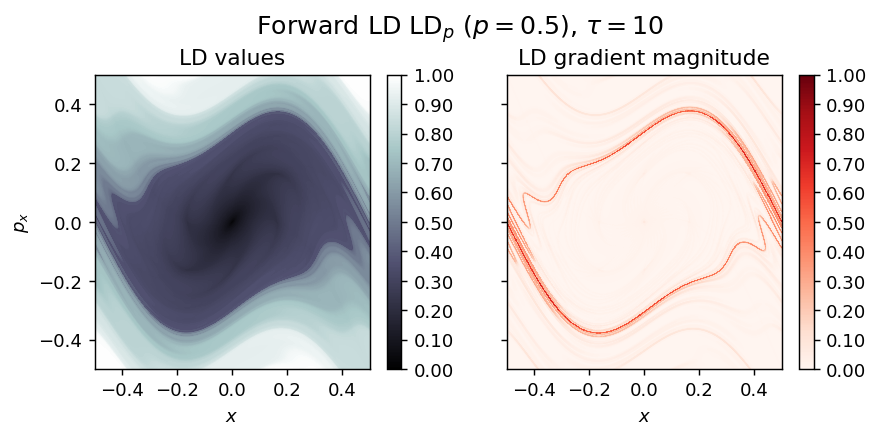

In [68]:
discrete_map = lambda u: StandardMap(u,PARAMETERS=[K])

LD_forward = compute_lagrangian_descriptor(grid_parameters, discrete_map, N_iterations, p_value)
draw_lagrangian_descriptor(LD_forward, 'forward', grid_parameters, N_iterations, p_value)

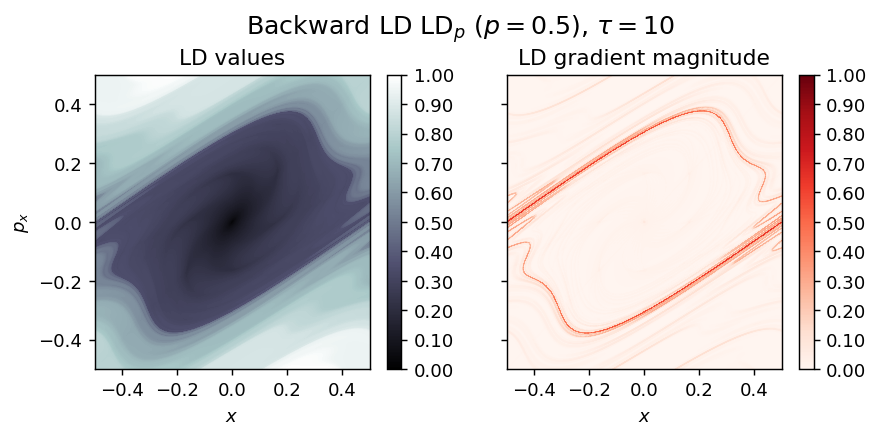

In [69]:
discrete_map = lambda u: StandardMap_inverse(u,PARAMETERS=[K])

LD_backward = compute_lagrangian_descriptor(grid_parameters, discrete_map, N_iterations, p_value)
draw_lagrangian_descriptor(LD_backward, 'backward', grid_parameters, N_iterations, p_value)

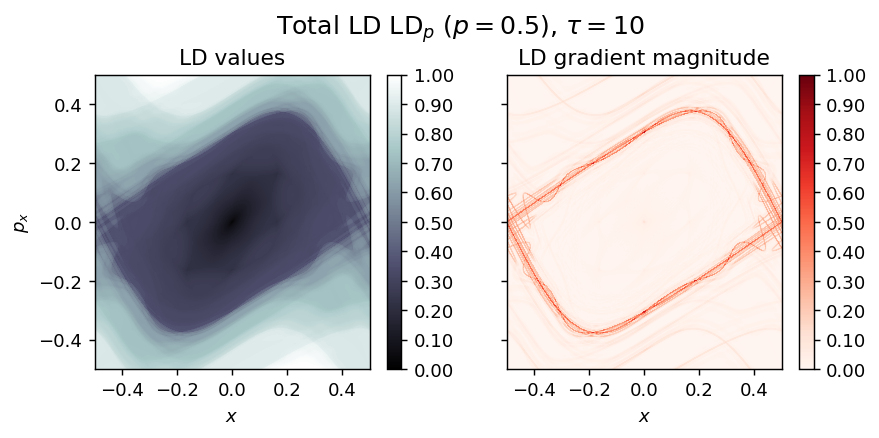

In [70]:
LD_total = LD_forward + LD_backward
draw_lagrangian_descriptor(LD_total, 'total', grid_parameters, N_iterations, p_value)

## Hènon map

REFERENCES

* https://mathworld.wolfram.com/HenonMap.html
* https://en.wikipedia.org/wiki/H%C3%A9non_map

In [98]:
import numpy as np

def HenonMap(u_initial, PARAMETERS=[1.4, 0.3]):
    """
    Returns 1D Hamilton-Centre vector field at time t, for an array of points in phase space.
    Number of model parameters: 1 . PARAMETERS = [omega]
    Functional form: v = (omega*y, - omega*x), with u = (x, y)
    
    Parameters
    ----------
    u : array_like, shape(n,)
        points in phase space to determine vector field at time t
    
    PARAMETERS : list of floats
        vector field parameters
    
    Returns
    -------
    v : array_like, shape(n,)
        vector field corresponding to points u, in phase space at time t
    """
    x_initial, y_initial = u_initial.T
    # Hamiltonian Model Parameter
    a, b = PARAMETERS
    
    # Map components
    x_next = 1 -a*x_initial**2 + y_initial
    y_next = b*x_initial
    
    # Map next iteration
    u_next = np.array([ x_next, y_next]).T
    
    return u_next

In [99]:
GRID_PARAMETERS = [[-1.5, 1.5, 20],[-1.5, 1.5, 20]]

In [100]:
points_original = generate_points(GRID_PARAMETERS)

N_iterations = 10
f = HenonMap

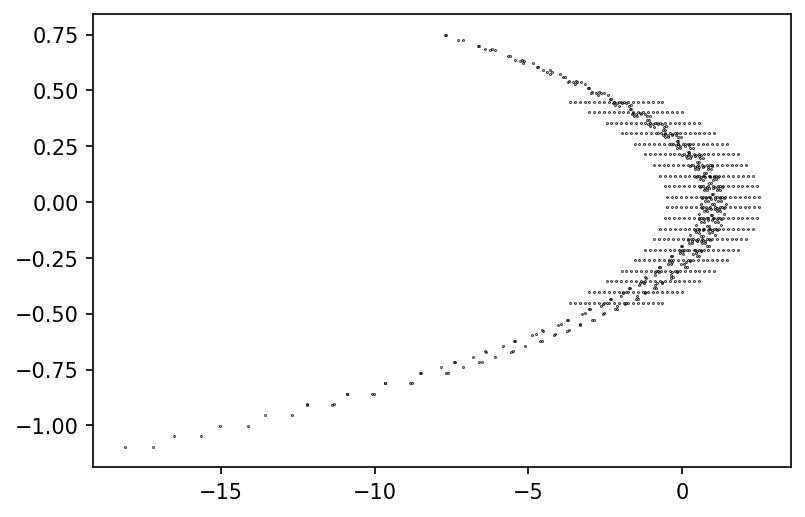

In [103]:
import matplotlib.pyplot as plt

fig = plt.figure(dpi=150)

for k in range(len(points_original)):
    points_initial = points_original[k]
    trajectory = []
    for i in range(2):
        points_next = f(points_initial)
        trajectory.append(points_next)
        
        points_initial = points_next
        
    plt.scatter(*np.array(trajectory).T,c='k',s=0.1)

plt.show()

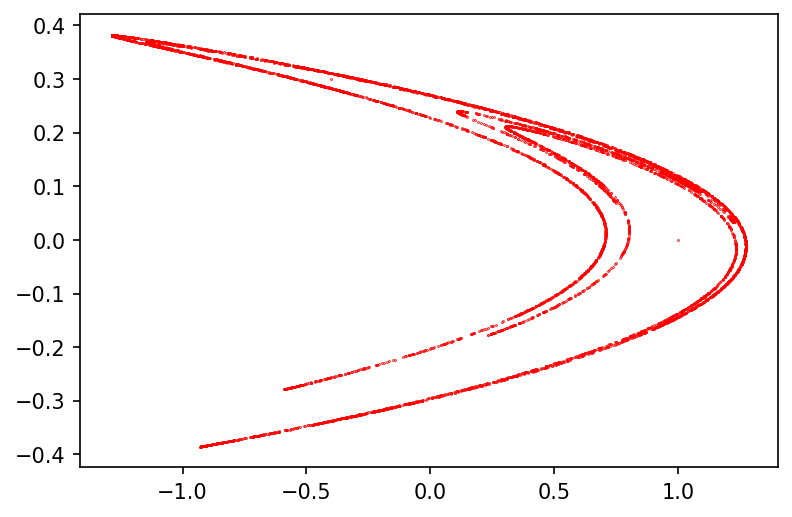

In [122]:
import matplotlib.pyplot as plt

fig = plt.figure(dpi=150)

points_initial = np.array([0,0])

trajectory = []
for i in range(6000):
    points_next = f(points_initial, PARAMETERS=[1.4, 0.3])
#     points_next = f(points_initial, PARAMETERS=[0.2, 0.9991])
    trajectory.append(points_next)
    points_initial = points_next

plt.scatter(*np.array(trajectory).T,c='red',s=0.1)

plt.show()

# Appendix

## Fast recursion using decorators

SOURCE

* https://realpython.com/python-thinking-recursively/#recursive-functions-in-python

In [249]:
def fibonacci_recursive(n):
#     print("Calculating F", "(", n, ")", sep="", end=", ")
    # Base case
    if n == 0:
        return 0
    elif n == 1:
        return 1

    # Recursive case
    else:
        return fibonacci_recursive(n-1) + fibonacci_recursive(n-2)

In [252]:
fibonacci_recursive(40)

KeyboardInterrupt: 

In [253]:
from functools import lru_cache

@lru_cache(maxsize=None)
def fibonacci_recursive(n):
#     print("Calculating F", "(", n, ")", sep="", end=", ")

    # Base case
    if n == 0:
        return 0
    elif n == 1:
        return 1

    # Recursive case
    else:
        return fibonacci_recursive(n-1) + fibonacci_recursive(n-2)

In [254]:
fibonacci_recursive(40)

102334155